# Genetic optimization of Decision Tree classifier for the SDSS data

## Load data

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [5]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {
    "criterion": ['gini', 'entropy'],
    "splitter": ['best', 'random'],
    "max_depth": np.arange(1,10),
    "min_weight_fraction_leaf": np.logspace(-3,0,base=10,num=20),
    "max_leaf_nodes": np.arange(1,10),
    "presort": [True, False],
    "min_samples_split": range(2, 10),
    "min_samples_leaf": range(1, 10),
    "max_features": ['auto', 'log2', None],
    "random_state": [42]
}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=DecisionTreeClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=3,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=50,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X, y)

Types [1, 1, 1, 2, 1, 1, 1, 1, 1, 1] and maxint [1, 1, 8, 19, 8, 1, 7, 8, 2, 0] detected


/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[CV] criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=4, presort=False, min_samples_split=5, min_samples_leaf=8, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=6,

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=9, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.5787106446776612, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.5877938969484743, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.03792690190

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42, score=0.9344672336168084, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=4, presort=False, min_samples_split=5, min_samples_leaf=8, max_features=auto, random_state=42, score=0.7163581790895448, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=log2, random_state=42, score=0.9815, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=

[CV] criterion=entropy, splitter=random, max_depth=9, min_weight_fraction_leaf=1.0, max_leaf_nodes=1, presort=False, min_samples_split=4, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=1, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=auto, random_state=42, score=0.49975012493753124, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=False, min_samples_split=2, min_samples_leaf=3, max_features=auto, random_state=42, score=0.489, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6

[CV] criterion=gini, splitter=random, max_depth=4, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=1, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42, score=0.9765117441279361, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=auto, random_state=42, score=0.49974987493746875, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=7, min_weight_fraction_leaf=0.00885866790410082

[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=8, max_features=auto, random_state=42, score=0.9325337331334332, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=8, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42, score=0.9744872436218109, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_l

[CV]  criterion=gini, splitter=random, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42, score=0.5377688844422212, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=2, min_weight_fraction_leaf=0.6951927961775606, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=1, presort=False, min_

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=4, presort=False, min_samples_split=5, min_samples_leaf=4, max_features=log2, random_state=42, score=0.49975012493753124, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=4, presort=False, min_samples_split=5, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9104552276138069, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.845, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_wei

[CV]  criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=4, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.4375, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.8579289644822411, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=4, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=1, presort=False, min_samples_split=2, min_samples_leaf=1, max_features=auto, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fra

[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=True, min_samples_split=8, min_samples_leaf=1, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=True, min_samples_split=8, min_samples_leaf=1, max_features=auto, random_state=42, score=0.5392696348174087, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=8, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=3, presort=True, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42, score=0.49974987493746875, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=1, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42, score=0.853, total=   0.0s
[CV] criterion=gini, splitter

[CV]  criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=1, max_features=auto, random_state=42, score=0.489, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=1, max_features=auto, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.3359818286283781, max_lea

[CV] criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=6, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=7, presort=False, min_samples_split=9, min_samples_leaf=2, max_features=None, random_state=42, score=0.49975012493753124, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=6, presort=True, min_samples_split=8, min_samples_leaf=7, max_features=log2, random_state=42, score=0.5377688844422212, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=7, presort=False, min_samples_split=9, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.0088586

[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=7, presort=False, min_samples_split=9, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=1, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=1, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, min_samples

[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, min_samples_split=4, min_samples_leaf=9, max_features=auto, random_state=42, score=0.6065, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9775112443778111, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=2, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, mi

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=1, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=4, max_features=auto, random_state=42, score=0.5042521260630315, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=8, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9825, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes

[CV] criterion=entropy, splitter=random, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=1.0, max_leaf_nodes=3, presort=True, min_samples_split=5, min_samples_leaf=7, max_features=auto, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=1.0, max_leaf_nodes=3, presort=True, min_samples_split=5, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=4, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=False, min_samples_split=5, min_samples_leaf=1, max_features=auto, random_state=42, score=0.463768115942029, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=4, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=Fa

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=4, presort=False, min_samples_split=9, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=2, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9754877438719359, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=2, presort=False, min_sampl

[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=3, presort=True, min_samples_split=4, min_samples_leaf=8, max_features=log2, random_state=42, score=0.49975012493753124, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=2, max_features=log2, random_state=42, score=0.5405, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=2, max_features=None, random_state=42, score=0.4375, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=8, min_weight_fraction_

[CV] criterion=entropy, splitter=random, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=1, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=3, presort=True, min_samples_split=4, min_samples_leaf=8, max_features=log2, random_state=42, score=0.49974987493746875, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=auto, random_state=42, score=0.48375812093953025, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=auto, random_state=42, score=0.5627813906953477, total=   0.0s
[CV] criterion=gini, splitter=random, max_de

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.6951927961775606, max_leaf_nodes=2, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=6, min_weight_fraction_leaf=0.6951927961775606, max_leaf_nodes=2, presort=False, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=1.0, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=1.0, max_leaf_nodes=6, presort=True, min_samples_split=6

[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=6, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=2, presort=False, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=6, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42, score=0.5182408795602199, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=7, presort=True, min_samples_sp

[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=1, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=1, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629,

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=5, min_samples_leaf=1, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=1, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=2, presort=False, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42, score=0.5, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=4, min_samples_leaf=1, max_features=auto, random_state=42, score=0.5217391304347826, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=1, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=2, presort=False, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=7, min_weight_fraction_l

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.4927536231884058, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, pr

[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.6951927961775606, max_leaf_nodes=1, presort=False, min_samples_split=8, min_samples_leaf=7, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42, score=0.7345, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=5, presort=True, min_samples_split=5, min_samples_leaf=8, max_features=auto, random_state=42, score=0.5935, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=5, 

[CV]  criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=log2, random_state=42, score=0.49975012493753124, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=6, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=log2, random_state=42, score=0.49975012493753124, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=6, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=9, min_weight_fraction_leaf=0.

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=2, max_features=auto, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=6, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=4, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=gini, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=5, min_samples_leaf=3, ma

[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=6, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=8, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42, score=0.5695, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=7, presort=True, m

[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=6, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=4, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.5287643821910956, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42, score=0.9150424787606197, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.00297635144163131

[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42, score=0.931, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=2, presort=False, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.5297648824412207, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=9, min_weight_fraction_leaf=0.05455594781168517, max_l

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=8, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=5, presort=True, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42, score=0.9110444777611194, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=5, presort=True, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_sample

[CV] criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=8, max_features=log2, random_state=42, score=0.9724862431215607, total=   0.0s
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42, score=0.9824912456228114, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=auto, random_state=42, score=0.9219609804902451, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42, score=0.976488244122061, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.792, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=7, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=auto, random_state=42, score=0.9020489755122438, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=7, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max

[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=7, max_features=None, random_state=42, score=0.7576211894052973, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presor

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9789894947473737, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0183298071

[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42, score=0.9345, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, 

[CV]  criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.6498249124562281, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=8, max_features=auto, random_state=42, score=0.9054527263631816, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9549774887443722, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=8, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.9675, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=8, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9775112443778111, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=9, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, 

[CV] criterion=gini, splitter=best, max_depth=9, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=4, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=log2, random_state=42, score=0.984, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=4, presort=False, min_samples_split=4, 

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=False, min_samples_split=9, min_samples_leaf=3, max_features=auto, random_state=42, score=0.9164582291145573, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=1, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.5817091454272864, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_le

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=2, presort=False, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9110444777611194, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0183298071083243

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=auto, random_state=42, score=0.855927963981991, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42, score=0.9819909954977488, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=8, max_features=log2, random_state=42, score=0.974512743628186, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=5, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9544772386193097, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.2335721469090

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.05455594781168517, max_le

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.001, max_leaf_nodes=

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=log2, random_state=42, score=0.49974987493746875, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=5, max_features=log2, random_state=42, score=0.974512743628186, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=5, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9724862431215607, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42, score=0.979, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=2, min_s

[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=2, presort=False, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.9795, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.9874937468734367, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=8, min_samples_leaf=7, max_features=None, random_state=42, score=0.5817091454272864, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=8, min_weight_fraction_leaf=0.001438449

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=4, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=log2, random_state=42, score=0.9835082458770614, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9744872436218109, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=4, presort=False, min_samples_split=4, min_samples_leaf=5, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, pr

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=7, presort=True, min_samples_split=7, min_samples_leaf=2, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=4, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=log2, random_state=42, score=0.9744872436218109, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=4, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, 

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_

[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=5, max_features=log2, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9735132433783108, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_node

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=3, max_features=log2, random_state=42, score=0.9825, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=3, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.01832980710832

[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42, score=0.7435, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_le

[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=6, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.8579289644822411, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=log2, random_state=42, score=0.9735132433783108, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00428

[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=5, max_features=auto, random_state=42, score=0.936, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=5, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=log2, random_state=42, score=0.9719859929964982, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.008858667904100823, max_

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.912543728135932, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=auto, random_state=42, score=0.9119559779889945, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, ma

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0784759970351

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.989, total=   0.1s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf

[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9819909954977488, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, mi

[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42, score=0.9825, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=9, min_samples_leaf=9, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=True, min_sample

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=5, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42, score=0.9874937468734367, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=Tr

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9775112443778111, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=2, min_samples_leaf=5, max_features=log2, random_state=42, score=0.9799899949974987, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=7, presort=True, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_we

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00297635

[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_n

[CV]  criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9819909954977488, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479

[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.9835082458770614, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, m

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.9779889944972486, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, 

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.018329807108324

[CV]  criterion=gini, splitter=best, max_depth=2, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_le

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42, score=0.9825, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=False, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_le

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_w

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42, score=0.9829914957478739, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fractio

[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=3, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.919, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=3, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, p

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=8, min_

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_lea

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=9, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.00428133239871

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_

[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.004281332398719396, 

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_l

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_sam

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_node

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=2, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=7, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=2, presort=True, min_samp

[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=2, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=auto, random_state=42, score=0.5592796398199099, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.026366508987303583, max_leaf_n

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=1, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=1, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, mi

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.002976351441631319, 

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=False, min_s

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=False, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, 

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.988, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_lea

[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583

[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9104552276138069, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334,

[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.8105947026486756, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=7, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.01274274985703133

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583,

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, ma

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_sam

[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=3, presort=True, 

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=3, presort=False, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=

[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=3, presort=False, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=3, presort=False, min_samples_split=7, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, 

[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303

[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weig

[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.037926

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=False, min_samples_split=2, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=5, presort=False, min_samples_split=4, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min

[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.988, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.657, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nod

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=4, max_fea

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.00206913808111479, max_leaf_no

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.4832930238571

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.8579289644822411, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0029763514416313

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=5, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False,

[CV]  criterion=gini, splitter=best, max_depth=6, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=6, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.01274274985703133

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=7, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0379269019073225, max_leaf_node

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42, score=0.9884942471235618, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_sa

[CV]  criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=7, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_sampl

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00297635144163131

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.07847599703514

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
7  	56    	0.975202	0.5181	0.9885	0.0675136
[CV

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00428133239871939

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.00143844988828766

[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_d

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=5, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_d

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.1s
[CV]  criterion=gini, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=7, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=1, min

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=5, presort=True, min_samples_split=3, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_s

[CV] criterion=gini, splitter=best, max_depth=5, min_weight_fraction_leaf=0.001, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9874937468734367, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9815, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=8, p

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.5847076461769115, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pr

[CV] criterion=gini, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
8  	70    	0.977532	0     	0.9885	0.098543 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best,

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_w

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9825, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0379269019073225, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=log2, random_state=42, score=0.9815, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3,

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_we

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=8, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=9, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=9, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=9, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.989, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, mi

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, mi

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9819909954977488, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.7896051974012993, total=   0.0s
[CV] criterion=gini, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, preso

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=log2, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_node

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=9, min_samples_leaf=8, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3,

[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42, score=0.9054527263631816, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9825087456271864, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fract

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=8, presort=True, min_samples_split=2, min_samples_leaf=9, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_d

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.00143

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0088586679041008

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s


[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9885, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, m

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.001438449888287662

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=8, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876

[CV] criterion=entropy, splitter=random, max_depth=2, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presor

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort

[CV] criterion=gini, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42, score=0.9824912456228114, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, 

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weig

[CV]  criterion=entropy, splitter=random, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV] criterion=entropy, splitter=best,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
14 	60    	0.962644	0     	0.9896	0.146121   
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.6951927961775606, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.6951927961775606, max

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9894947473736868, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9894947473736868, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fr

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42, score=0.9084542271135568, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.05455594781168517, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
17 	69    	0.988529	0.9217	0.9896	0.00726623 
[CV] criterion=entropy, splitter=bes

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42, score=0.982, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895052473763118, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s


[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presor

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, 

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presor

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42, score=0.6086956521739131, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presor

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.573, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=False, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presor

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.11288378916846

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.968015992003998, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, 

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=6, max_features=log2, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=7, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42, score=0.9245, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=auto, random_state=42, score=0.62, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fract

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=log2, random_state=42, score=0.9824912456228114, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_n

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9104552276138069, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, mi

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.8649324662331166, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.4832930238571752, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, 

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=auto, random_state=42, score=0.9405297351324338, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=auto, random_state=42, score=0.9084542271135568, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
26 	70    	0.984387	0.8475	0.9896	0.0232009  
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=bes

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.968015992003998, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_sampl

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.07847599703514611, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=auto, random_state=42, score=0.936, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.018329807108324356, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, preso

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.975512243878061, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42, score=0.9180409795102449, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828766

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pre

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=8, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42, score=0.9054527263631816, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9104552276138069, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9819909954977488, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.913, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9120439780109945, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.912456228114057, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9825087456271864, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895052473763118, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_w

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_sample

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.913, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.23357214690901212, max_leaf_nodes=9, presort=True, min_sample

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=1, presort=True, min_samples_

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=6, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.968015992003998, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.991504247876062, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.987, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.002976351441631319, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42, score=0.9110444777611194, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=3, max_features=None, random_state=42, score=0.912456228114057, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287662

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42, score=0.9890054972513743, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287662

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presort

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.11288378916846883, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9675, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.11288378916846883, max_leaf_n

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=1.0, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True,

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fr

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.8289144572286143, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=7, min_samples_leaf=6, max_features=log2, random_state=42, score=0.9785107446276862, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828766

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895052473763118, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9869934967483742, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_

[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_node

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=4, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_s

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=log2, random_state=42, score=0.9785107446276862, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.3359818286283781, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, 

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
40 	63    	0.986382	0.8795	0.9896	0.0156396  
[CV] criterion=entropy, splitter=bes

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=8, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_wei

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=4, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=6, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=auto, random_state=42, score=0.9390304847576212, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=7, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_lea

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s


[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.968015992003998, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895052473763118, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=Tr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=False, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.657, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.018329807108324356, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0183298071083

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9825087456271864, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_lea

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.026366508987303583, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9905047476261869, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weig

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42, score=0.989, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.657, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=2, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42, score=0.5597798899449725, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.001438

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=4, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best,

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=9, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=5, min_samples_leaf=6, max_features=auto, random_state=42, score=0.935032483758121, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42, score=0.9824912456228114, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.012742749857031334, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=4, max_features=log2, random_state=42, score=0.9800099950024987, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=2, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=8, min_samples_leaf=8, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=8, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=8, min_samples_leaf=8, max_features=None, random_state=42 
45 	45    	0.978959	0     	0.9896	0.0985317  
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_de

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=3, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.008858667904100823, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9895052473763118, total=   0.0s
[CV] criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287662

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00206913808111479, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9874937468734367, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=8, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=auto, random_state=42, score=0.9235, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV]  criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=5, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=gini, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=5, presort=True, min_samples_split=5, min_samples_leaf=1, max_features=auto, random_state=42, score=0.7093546773386693, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828766

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=1, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=1, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min

[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.0, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=1, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.00143844988828766

[CV]  criterion=entropy, splitter=best, max_depth=8, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=9, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=log2, random_state=42, score=0.9824912456228114, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9829914957478739, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.913, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828766

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=5, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=4, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.004281332398719396, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=8, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=4, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_l

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_sample

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_le

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV]  criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=7, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, m

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9900049975012494, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.006158482110660267, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9879939969984992, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.1s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, 

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=auto, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=auto, random_state=42, score=0.9180409795102449, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=log2, random_state=42, score=0.9825087456271864, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=log2, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_sample

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=False, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=9, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=random, 

[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.1s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=auto, random_state=42, score=0.9084542271135568, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=7, presort=True, min_samples_split=6, min_samples_leaf=1, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=2, min_samples_leaf=6, max_features=None, random_state=42, score=0.5132433783108445, total=   0.0s
[CV] criterion=entropy, splitter=random

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pr

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=1, min_weight_fraction_leaf=0.00143844988828

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.913, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=2, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, pres

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
49 	58    	0.981196	0.5181	0.9896	0.0500161  
[CV]  criterion=entropy, splitter=be

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9290354822588706, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.1623776739188721, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, mi

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9930034982508745, total=   0.0s
[CV] criterion=entropy, splitter=best, ma

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=2, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, preso

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001438449888287

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=best, m

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9889944972486243, total=   0.0s
[CV]  criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42, score=0.806903451725863, total=   0.0s
[CV] criterion=entropy, splitter=random, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=6, max_features=None, random_state=42 
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.

[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=2, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=6, max_features=None, random_state=42, score=0.9854927463731866, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.001

[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42, score=0.9910044977511244, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=6, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42, score=0.9895, total=   0.0s
[CV] criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.0014384498882876629, max_leaf_nodes=9, presort=True, min_samples_split=3, min_samples_leaf=3, max_features=None, random_state=42 
[CV]  criterion=entropy, splitter=best, max_depth=3, min_weight_fraction_leaf=0.00143844988828

Data Set Type:  Standard Scaled
DecisionTreeClassifier
[0.98800799 0.98667555 0.992      0.98665777 0.99199466]
Accuracy: 0.989 (+/- 0.005)
DecisionTreeClassifier :
 [[1229   10    7]
 [  17  225    0]
 [   2    0 1010]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1246
         QSO       0.96      0.93      0.94       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
DecisionTreeClassifier 0.9890671958520871


By Precision(avg=micro):
DecisionTreeClassifier 0.9856


By Recall(avg=micro):
DecisionTreeClassifier 0.9856


By F1(avg=micro):
DecisionTreeClassifier 0.9856


By Precision(avg=macro):
DecisionTreeClassifier 0.9784464867841351


By Recall(avg=macro):
DecisionTreeClassifier 0.9713773739398824


By F1(avg=macro):
DecisionTreeClassifier 0.97484

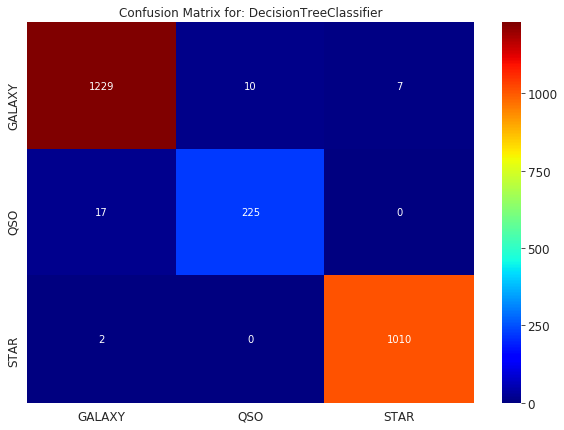

In [6]:
best_indiv = DecisionTreeClassifier(criterion="entropy",
                               splitter="best",
                               max_depth=3,
                               min_weight_fraction_leaf=0.0014384498882876629,
                               max_leaf_nodes=9,
                               presort=True,
                               min_samples_split=6,
                               min_samples_leaf=4,
                               max_features=None,
                               random_state=42)

clf_names = ["DecisionTreeClassifier"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs=[best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)